# Open questions 

(?) Should data from #GivingTuesday be analyzed separately?

(?) Does it make sense to substitute the number of transactions on #GivingTuesday with the second highest number of transaction during the year? or should we just calculate the avg number of transactions without givingtuesday and use that value? 


## TODOS - if necessary 

* Plots with different channels - split into different plots (one plot per channel), to be able to see differences 
* Check percentage of clients/transactions per channel 
    - whole year 
    - #GivingTuesday 
* Plots/tables of clients/transactions per channel and hozur (?)/day/week/month 
* Figure out emails or specific campaigns - how are they influencing the results? 
* Impute missing data in empty channels (see youtube ads)
* plot of channels vs transactions revenue 
* check ratio unique clients ID / transactions 
    - per day 
    - on giving Tuesday 
    - per channel group 

# Part I. EDA 


## Getting data from Supermetrics

Follow tutorial https://supermetrics.com/blog/how-to-load-data-into-mysql

Urls are stored in 'constants.py', which will not be pushed into the repo. Urls contain the supermetrics queries for different timeframes in 2021. At first, just basic information (client IDs, transaction yes/no + transaction amount) are imported

After some trials with different time frames, I finally decided to work with 12 months (01.01.2021 - 31.12.2021)

Steps to import data from supermetrics: 

* Import urls from constant file
* Call API 
* Check response - response needs to be 200 to be successfull; 500 indicates error

In [1]:
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 


*url* contains the basic information about Client ID and transactions 

In order to import other features of interest, two additional URLs were created (one was not enough, because just 9 features are allowed). Those are *url_extended1* and *url_extended2*. I will import them and join them in a complete table. 


In [27]:
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module 


# to reload modules that have changed: 
# https://stackoverflow.com/questions/33323707/how-do-i-reload-a-module-after-changing-it 

In [29]:
importlib.reload(constants_year_MT)
import constants_year_MT as constants 

In [30]:
help(constants)

Help on module constants_year_MT:

NAME
    constants_year_MT - # urls for basic table - all client IDS

DATA
    hello = '123'
    url_12months = 'https://api.supermetrics.com/enterprise/v2/query...VMi...
    url_12months_extended_part1 = 'https://api.supermetrics.com/enterprise...
    url_12months_extended_part2 = 'https://api.supermetrics.com/enterprise...

FILE
    c:\users\carol\onedrive\escritorio\fh kufstein\mt\analysis\python\constants_year_mt.py




In [33]:
# import basic table + call API + check response (200 for ok, 500 for error)
# takes 5-10 seconds 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months 
response_basic = requests.get(url_12months)
print(response_basic)

<Response [200]>


In [34]:
# import extended table, part 1 (session info)
# takes 2-3 minutes 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_extended_part1
response_extended1 = requests.get(url_12months_extended_part1)
print(response_extended1)

<Response [200]>


In [35]:
# import extended table, part 2 (demographic info)
# takes 2-3 minutes
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_extended_part2
response_extended2 = requests.get(url_12months_extended_part2)
print(response_extended2)

<Response [200]>


### Create table from url data 

* Define function 
* Apply to different URLs

In [36]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [180]:
# create data frame for complete year 2021 - basic features 
df_basic = url_to_df(url_12months, response_basic)
df_basic

,clientID,Date,Channel group,Users,Transactions,Transaction revenue
0,669558.1609495171,2021-01-01,Display,1,0,0
1,1090275.1606543939,2021-01-01,Display,1,0,0
2,1184473.1609510423,2021-01-01,Paid Search,1,0,0
3,1291193.1590344615,2021-01-01,Display,1,0,0
4,1309756.1608377368,2021-01-01,Display,1,0,0
...,...,...,...,...,...,...
442099,2042738099.1640943457,2021-12-31,Email,1,0,0
442100,2042766705.1635368625,2021-12-31,Email,1,0,0
442101,2043533916.1640950150,2021-12-31,Branded Paid Search,1,0,0
442102,2047304846.1640943758,2021-12-31,Email,1,0,0


In [38]:
# create dataframe for year 2021 - extended set of features 
df_extended1 = url_to_df(url_12months_extended_part1, response_extended1)
df_extended2 = url_to_df(url_12months_extended_part2, response_extended2)

Dimension of both tables are different (466.287 df_extended1 vs 421.542 df_extended2 vs 442.104 df_basic) - I do not know why, but I will do an inner join and keep all common client IDs in both tables. 

In [181]:
# join df_extended1 and df_extended2 using common features (specially clientID & Date)
df_extended = pd.merge(df_extended1, df_extended2, how = 'left', on = ['clientID', 'Date', 'Users', 'Transactions'])
df_extended

,clientID,Date,Source,Medium,Channel group,Keyword,User type,Operating system,Users,Transactions,...,City,Latitude,Longitude,Transaction revenue,Pageviews,Hits,Total time on site,Sessions,Bounces,Total events
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,(direct),(none),Direct,(not set),New Visitor,Android,1,0,...,Pisek,49.3035,14.1580,0,16,16,391,1,0,0
1,883.1608633267,2021-10-04,google,cpc,Branded Paid Search,sos kinderdorf,New Visitor,Windows,1,0,...,Vienna,48.2082,16.3738,0,3,13,118,2,0,10
2,883.1608633267,2021-10-04,sos-kinderdorf.bewerberportal.at,referral,Referral,(not set),Returning Visitor,Windows,1,0,...,Vienna,48.2082,16.3738,0,3,13,118,2,0,10
3,1872.1612460548,2021-02-04,google,organic,Organic Search,(not provided),New Visitor,Android,1,0,...,Vienna,48.2082,16.3738,0,2,3,48,1,0,1
4,12568.1632331399,2021-09-22,google,cpc,Branded Paid Search,sos spenden,New Visitor,Android,1,0,...,Vienna,48.2082,16.3738,0,1,2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471527,2072241362.1615285398,2021-03-15,google,organic,Organic Search,(not provided),Returning Visitor,Macintosh,1,0,...,Vienna,48.2082,16.3738,0,6,19,179,1,0,13
471528,2073949203.1615097577,2021-03-15,google,organic,Organic Search,(not provided),Returning Visitor,iOS,1,0,...,(not set),0.0000,0.0000,0,2,2,1,1,0,0
471529,2075166178.1615823883,2021-03-15,google,organic,Organic Search,(not provided),New Visitor,iOS,1,0,...,Schwabach,49.3289,11.0245,0,3,6,22,1,0,3
471530,2076218022.1615823456,2021-03-15,google,cpc,Generic Paid Search,Dynamic Search Ads,New Visitor,Android,1,0,...,Linz,48.3069,14.2858,0,2,2,2,1,0,0


In [182]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471532 entries, 0 to 471531
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   clientID             471532 non-null  object
 1   Date                 471532 non-null  object
 2   Source               471532 non-null  object
 3   Medium               471532 non-null  object
 4   Channel group        471532 non-null  object
 5   Keyword              471532 non-null  object
 6   User type            471532 non-null  object
 7   Operating system     471532 non-null  object
 8   Users                471532 non-null  object
 9   Transactions         471532 non-null  object
 10  Region               470154 non-null  object
 11  Country              470154 non-null  object
 12  City                 470154 non-null  object
 13  Latitude             470154 non-null  object
 14  Longitude            470154 non-null  object
 15  Transaction revenue  470154 non-nu

(!) It would be interesting to know how many levels do exist and how many cases of each

Available features: 
* `clientID` - user identifier 
* `Date`
* `Source` - source of user (google, facebook, direct, etc)
* `Medium` - type of referrals. Directly related to `Source`
    - `utm_medium` - if manual campaign tracking 
    - `cpc` if google ads 
    - `organic` if users came from a search engine detected by google analytics 
    - `referral ` if referrer is not a search engine 
    - `(none)` (empty) if users came directly to the webpage 
* `Channel group` - where user comes from (referral, branded paid search, generic paid search, organic search)
* `keyword` - if coming from google 
* `User Type` - new/retourning visitor 
* `Operating system`
* `Users` - all 1, but we can use it to count users per day 
* `Transactions, Transaction revenue` - indicate if transaction exists or not + revenue 
* `Region, City, Latitude, Longitude`
* `Pageviews` 
* `Hits` - total number of hits for the view (pageview, custom event, etc)
* `Total time on site`
* `Sessions` - group of user interactions with your website that takes place within a given time frame
* `Bounces` - total number of single page (or single interaction hit) sessions 
* `Total events` - user interactions with the website that cannot be tracked


In [43]:
test1 = df_extended[df_extended['Users'] > 1]
test1

,clientID,Date,Source,Medium,Channel group,Keyword,User type,Operating system,Users,Transactions,...,City,Latitude,Longitude,Transaction revenue,Pageviews,Hits,Total time on site,Sessions,Bounces,Total events


As we can see, all features are of type "object" - we need to change this

In [45]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471532 entries, 0 to 471531
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   clientID             471532 non-null  object
 1   Date                 471532 non-null  object
 2   Source               471532 non-null  object
 3   Medium               471532 non-null  object
 4   Channel group        471532 non-null  object
 5   Keyword              471532 non-null  object
 6   User type            471532 non-null  object
 7   Operating system     471532 non-null  object
 8   Users                471532 non-null  object
 9   Transactions         471532 non-null  object
 10  Region               470154 non-null  object
 11  Country              470154 non-null  object
 12  City                 470154 non-null  object
 13  Latitude             470154 non-null  object
 14  Longitude            470154 non-null  object
 15  Transaction revenue  470154 non-nu

Also, we can see how socio-demographic features (Region, Country, City, Latitude, Longitude) have missing values - less missing values now?? I dont get it... 

In [183]:
df_extended.isna().sum()

0
clientID                  0
Date                      0
Source                    0
Medium                    0
Channel group             0
Keyword                   0
User type                 0
Operating system          0
Users                     0
Transactions              0
Region                 1378
Country                1378
City                   1378
Latitude               1378
Longitude              1378
Transaction revenue    1378
Pageviews              1378
Hits                   1378
Total time on site     1378
Sessions               1378
Bounces                1378
Total events           1378
dtype: int64

## Data pretreatment 

Transform data into correct format

In [47]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f == 'Date':
            df[f] = pd.to_datetime(df[f])
        else: # all numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

In [184]:
feats_to_convert_for_basic = ['Date', 'Users', 'Transactions', 'Transaction revenue']
df_basic = transform_class(df_basic, feats_to_convert_for_basic)

In [185]:
feats_to_convert_for_extended = ['Date', 'Users', 'Transactions', 'Transaction revenue', 'Pageviews', 'Hits', 'Total time on site', 'Bounces', 'Total events', 'Latitude', 'Longitude']
df_extended = transform_class(df_extended, feats_to_convert_for_extended)

In [64]:
# check final table to work with 
df_extended

,clientID,Date,Source,Medium,Channel group,Keyword,User type,Operating system,Users,Transactions,...,City,Latitude,Longitude,Transaction revenue,Pageviews,Hits,Total time on site,Sessions,Bounces,Total events
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,(direct),(none),Direct,(not set),New Visitor,Android,1,0,...,Pisek,49.3035,14.1580,0.0,16.0,16.0,391.0,1,0.0,0.0
1,883.1608633267,2021-10-04,google,cpc,Branded Paid Search,sos kinderdorf,New Visitor,Windows,1,0,...,Vienna,48.2082,16.3738,0.0,3.0,13.0,118.0,2,0.0,10.0
2,883.1608633267,2021-10-04,sos-kinderdorf.bewerberportal.at,referral,Referral,(not set),Returning Visitor,Windows,1,0,...,Vienna,48.2082,16.3738,0.0,3.0,13.0,118.0,2,0.0,10.0
3,1872.1612460548,2021-02-04,google,organic,Organic Search,(not provided),New Visitor,Android,1,0,...,Vienna,48.2082,16.3738,0.0,2.0,3.0,48.0,1,0.0,1.0
4,12568.1632331399,2021-09-22,google,cpc,Branded Paid Search,sos spenden,New Visitor,Android,1,0,...,Vienna,48.2082,16.3738,0.0,1.0,2.0,0.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471527,2072241362.1615285398,2021-03-15,google,organic,Organic Search,(not provided),Returning Visitor,Macintosh,1,0,...,Vienna,48.2082,16.3738,0.0,6.0,19.0,179.0,1,0.0,13.0
471528,2073949203.1615097577,2021-03-15,google,organic,Organic Search,(not provided),Returning Visitor,iOS,1,0,...,(not set),0.0000,0.0000,0.0,2.0,2.0,1.0,1,0.0,0.0
471529,2075166178.1615823883,2021-03-15,google,organic,Organic Search,(not provided),New Visitor,iOS,1,0,...,Schwabach,49.3289,11.0245,0.0,3.0,6.0,22.0,1,0.0,3.0
471530,2076218022.1615823456,2021-03-15,google,cpc,Generic Paid Search,Dynamic Search Ads,New Visitor,Android,1,0,...,Linz,48.3069,14.2858,0.0,2.0,2.0,2.0,1,0.0,0.0


### Create table of grouped values per date 

* Grouped values of numeric features 
* Add columns of number of unique and total client IDs (per day)

In [65]:
# create table of grouped df - with numeric values grouped by date 
df_grouped = df_extended[['Date', 'Users', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_grouped_by_date = df_grouped.groupby(['Date']).sum() 
df_grouped_by_date

,Users,Transactions,Transaction revenue,Total time on site,Pageviews,Hits,Total events
Date,,,,,,,
2021-01-01,4712,40,6090.3008,506024.0,8988.0,21801.0,12467.0
2021-01-02,4955,41,25736.0607,599749.0,9844.0,25301.0,15145.0
2021-01-03,5274,30,4040.9028,541384.0,10271.0,26265.0,15682.0
2021-01-04,5345,35,6509.8152,565354.0,11222.0,28305.0,16752.0
2021-01-05,4917,25,2530.4082,631299.0,10368.0,27018.0,16292.0
...,...,...,...,...,...,...,...
2021-12-27,2316,64,16089.6595,255575.0,5861.0,13080.0,6824.0
2021-12-28,2146,66,13222.4675,217249.0,5428.0,12191.0,6458.0
2021-12-29,1875,65,13978.8823,194325.0,5037.0,11823.0,6455.0


In [66]:
# table of unique client ID per date 
unique_client_ID = df_extended.groupby('Date')['clientID'].nunique().rename('unique_clientID')
unique_client_ID = unique_client_ID.to_frame()

# table of total client ID per date 
total_client_ID = df_extended.groupby('Date').size().values
df_client_ID  = unique_client_ID.assign(total_clientID = total_client_ID)

# merge df_grouped_by_date with df_client_ID 
df_grouped_by_date = pd.merge(df_grouped_by_date, df_client_ID, how = "left", on = "Date")
df_grouped_by_date

,Users,Transactions,Transaction revenue,Total time on site,Pageviews,Hits,Total events,unique_clientID,total_clientID
Date,,,,,,,,,
2021-01-01,4712,40,6090.3008,506024.0,8988.0,21801.0,12467.0,4389,4712
2021-01-02,4955,41,25736.0607,599749.0,9844.0,25301.0,15145.0,4581,4955
2021-01-03,5274,30,4040.9028,541384.0,10271.0,26265.0,15682.0,4943,5274
2021-01-04,5345,35,6509.8152,565354.0,11222.0,28305.0,16752.0,4930,5345
2021-01-05,4917,25,2530.4082,631299.0,10368.0,27018.0,16292.0,4557,4917
...,...,...,...,...,...,...,...,...,...
2021-12-27,2316,64,16089.6595,255575.0,5861.0,13080.0,6824.0,2056,2316
2021-12-28,2146,66,13222.4675,217249.0,5428.0,12191.0,6458.0,1927,2146
2021-12-29,1875,65,13978.8823,194325.0,5037.0,11823.0,6455.0,1658,1875


### Create table of channel + grouped features 

In [67]:
# create table of channel + group by channel group and date 
df_channel = df_extended[['Date', 'Users', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
df_grouped_by_channel

0                               Users  Transactions  Transaction revenue  \
Date       Channel group                                                   
2021-01-01 (Other)                  1             0               0.0000   
           Branded Paid Search    138            16            2614.7018   
           Direct                 152             5             644.4316   
           Display               3773             0               0.0000   
           Email                    6             1              79.2334   
...                               ...           ...                  ...   
2021-12-31 Generic Paid Search     24             0               0.0000   
           Organic Search         243            29            3954.2744   
           Referral                22             0               0.0000   
           Social                  44             0               0.0000   
           YouTube Ads              8             0               0.0000   

0                               Total time on site  Pageviews     Hits  \
Date       Channel group                                                 
2021-01-01 (Other)                            72.0        2.0      5.0   
           Branded Paid Search             48191.0      832.0   2715.0   
           Direct                          26900.0      496.0   1395.0   
           Display                        332731.0     5624.0  11494.0   
           Email                             521.0       18.0     54.0   
...                                            ...        ...      ...   
2021-12-31 Generic Paid Search              1401.0       53.0    134.0   
           Organic Search                  30456.0      688.0   1909.0   
           Referral                         4086.0       89.0    246.0   
           Social                           2250.0      100.0    263.0   
           YouTube Ads                        57.0       10.0     14.0   

0                               Total events  
Date       Channel group                      
2021-01-01 (Other)                       3.0  
           Branded Paid Search        1825.0  
           Direct                      861.0  
           Display                    5764.0  
           Email                        34.0  
...                                      ...  
2021-12-31 Generic Paid Search          76.0  
           Organic Search             1144.0  
           Referral                    158.0  
           Social                      162.0  
           YouTube Ads                   4.0  

[3446 rows x 7 columns]

TODO - other grouped tables of interest

## Descriptive analysis

The first step was to decide time range to work with, importing data from different time ranges (1/3/6/12 months). At the end, and because dataset had less than 1.000.000 rows (which is the maximum that it can be imported from Supermetrics), we decided to work with a whole year worth of data (2021). 

Data imported include all client IDs, i.e. those with and without transaction. As expected, the dataset is very imbalanced in terms of conversions - just 7.725 for the whole year.

Attention! Number of transactions != number of client IDs with transactions (more than one transaction may exist)

In [68]:
# check number of conversions 
df_extended['Transactions'].sum()

7725

### Client IDs

* Number of distinct client ID stays stable in df_basic and df_extended. 
* The difference between df_basic and df_extended is caused by repeated clients that accessed the webpage several times in a day through different sources. 
* The number of total client IDs in 2021 = 471.532 for the available data, from 323.353 different users. That number of different users may not be 100% real because 
    - Same user with different device has different client ID 
    - Users from iOS get a new client ID every 7 days 

In [64]:
# example of repeated clientID in same date 
df_extended[df_extended['clientID'] == '883.1608633267']

,clientID,Date,Source,Medium,Channel group,Keyword,User type,Operating system,Device category,Transactions,...,Pageviews,Hits,Total time on site,Bounces,Total events,Region,Country,City,Latitude,Longitude
1,883.1608633267,2021-10-04,google,cpc,Branded Paid Search,sos kinderdorf,New Visitor,Windows,desktop,0,...,1,6,16,0,5,NaN,NaN,NaN,NaN,NaN
2,883.1608633267,2021-10-04,sos-kinderdorf.bewerberportal.at,referral,Referral,(not set),Returning Visitor,Windows,desktop,0,...,2,6,102,0,4,NaN,NaN,NaN,NaN,NaN


In [74]:
# check single client IDs - extended 
unique_client_ids = df_extended.clientID.value_counts()
print('Total number of rows (client IDs, new or repeated):', len(df_extended))
print('Total number of distinct client IDs:', len(unique_client_ids))
print('Avg number of unique clientIDs per day:', round(len(unique_client_ids)/365, 2))

Total number of rows (client IDs, new or repeated): 471532
Total number of distinct client IDs: 323353
Avg number of unique clientIDs per day: 885.9


Check unique client IDs per day
* Client IDs can be repeated in different days
* The red line indicates the average number of clients per day, calculated as the total number of unique client IDs/365 
* As we can see, some peaks seem to exist - January, April, May, November and a big peak in December 
    - Some of them probably correspond to specific marketing (email) campaigns - ONGOING 
    - The peak in December (i.e. 31. November) corresponds to #GivingTuesday

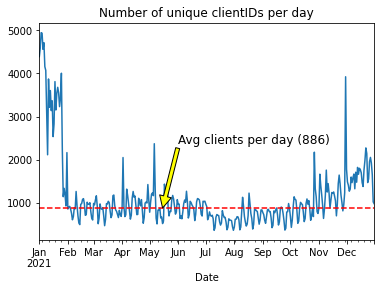

In [188]:
# extract clients per day = sum of unique IDs per day  
# df['Date'].value_counts().plot()
df_extended.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = round(len(unique_client_ids)/365, 2), color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (886)',
              xy = ('2021-05-15', round(len(unique_client_ids)/365, 2)), 
              xytext =('2021-06-01', round(len(unique_client_ids)/365, 2) + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
# Annotation of peak of #GivingTuesday 
# TODO if necessary
plt.show()

Check number of (total) client IDs per channel group 

In [80]:
# reset_index() transform grouped table into normal table (with repeated Date)
df_grouped_by_channel2 = df_grouped_by_channel.reset_index()
#print(df_grouped_by_channel2)

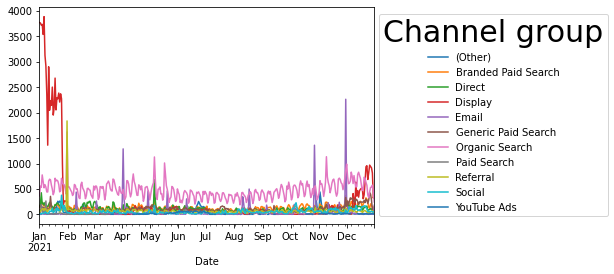

In [78]:
df_grouped_by_channel.unstack()['Users'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

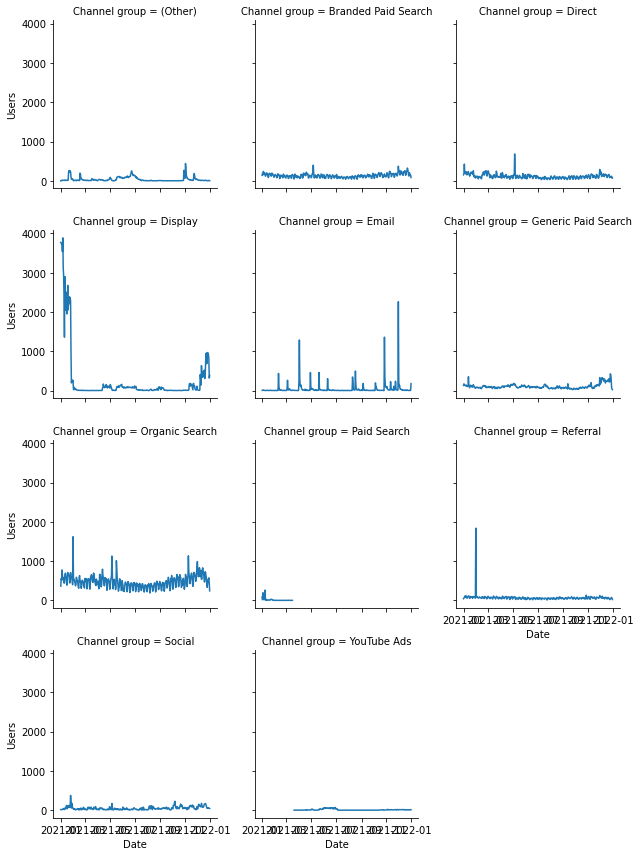

In [94]:
# plot each channel group into a different plot 
import seaborn 
grid = seaborn.FacetGrid(df_grouped_by_channel2, col = 'Channel group', col_wrap = 3)
grid.map(seaborn.lineplot, 'Date', 'Users')


### Transactions

* We observed that the same big peak in November existed as in client IDs 
* We compared the results with year 2020 - observing same peak at the same time 
* We then figured out that the peak was caused by #GivingTuesday 
    - We then wonder if #GivingTuesday should be analized separately 
* Also, we can see that the peak in transactions on #GivingTuesday is much bigger than the peak in clientIDs 
* Also, those transactions seem to mostly come from email marketing
* We can also observe how the peak/s in January on number of ClientIDs does not correlated with number of transactions on that month

#### Results with #GivingTuesday

In [97]:
df_transactions = df_extended[df_extended['Transactions'] > 0]
df_transactions_over1 = df_transactions[df_transactions['Transactions'] > 1]
total_number_transactions = df_transactions['Transactions'].sum()
total_number_transactions_over1 = df_transactions_over1['Transactions'].sum() 

In [101]:
print('Total number of transactions: ', total_number_transactions)
print('Avg number of transactions per day:', round(total_number_transactions/365, 2))
print('Total number of clientIDs with transactions:', len(df_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_transactions_over1.clientID.value_counts()))

Total number of transactions:  7725
Avg number of transactions per day: 21.16
Total number of clientIDs with transactions: 6616
Total number of clientIDs with more than 1 transaction: 246


Because that big peak at the end of peak was "weird", we checked results in year 2020 - looked the same. We then figured out that the peak is caused by #GivingTuesday. 
**Evtl. new goal - are results the same on #GivingTuesday as the rest of the year?**

Text(2021-07-01, 1000, '#GivingTuesday')

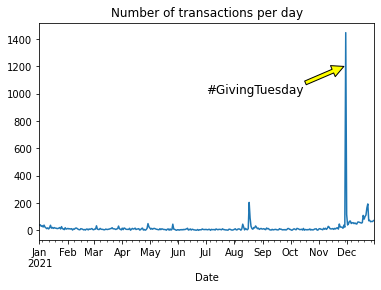

In [187]:
# check transactions per day 
df_extended.groupby('Date')['Transactions'].sum().plot()
plt.title("Number of transactions per day")
# add annotation of #givingtuesday 
plt.annotate('#GivingTuesday',
              xy = ('2021-11-28', 1200), 
              xytext =('2021-07-01',1000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))

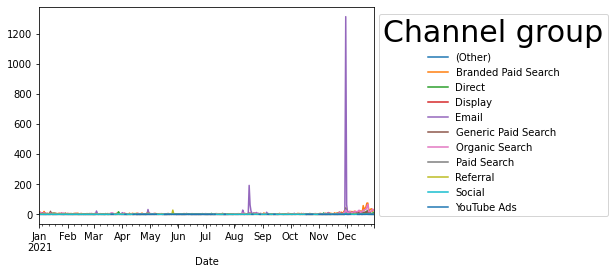

In [103]:
df_grouped_by_channel.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Results without #GivingTuesday (2021-11-30)

* Drop #GivingTuesday day - to make analysis easier 
* We still observe 2 peaks in the number of daily transactions
* Even without #GivingTuesday, data peaks seem to correspond to Email marketing. An increase in transactions from Organic Search and Branded Paid Search seems to exist by the end of the year as well


In [151]:
df_no_giving_tuesday = df_extended
df_no_giving_tuesday = df_no_giving_tuesday[df_no_giving_tuesday['Date'] != '2021-11-30']
df_no_giving_tuesday_with_transactions = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 0]
df_no_giving_tuesday_with_transactions_over1 = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 1]
avg_number_transactions_no_giving_tuesday = df_no_giving_tuesday.Transactions.sum() / 365

In [142]:
print('Results without Transactions from #GivingTuesday: ')
print('Total number of transactions: ', df_no_giving_tuesday.Transactions.sum())
print('Avg number of transactions per day:', round(df_no_giving_tuesday.Transactions.sum()/365, 2))
print('Total number of clientIDs with transactions:', len(df_no_giving_tuesday_with_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_no_giving_tuesday_with_transactions_over1.clientID.value_counts()))

Results without Transactions from #GivingTuesday: 
Total number of transactions:  6278
Avg number of transactions per day: 17.2
Total number of clientIDs with transactions: 5370
Total number of clientIDs with more than 1 transaction: 226


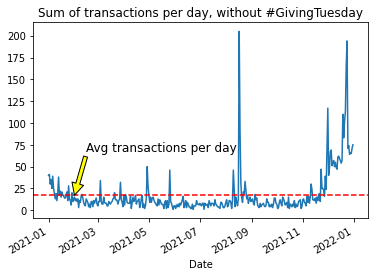

In [155]:
# check transactions per day - already grouped by date  
df_no_giving_tuesday_grouped = df_no_giving_tuesday.groupby(['Date'])['Transactions'].sum()
df_no_giving_tuesday_grouped.plot()
plt.axhline(y = avg_number_transactions_no_giving_tuesday, color = 'r', linestyle = '--')
plt.title("Sum of transactions per day, without #GivingTuesday")
# Annotation
plt.annotate('Avg transactions per day',
              xy = ('2021-02-01', avg_number_transactions_no_giving_tuesday), 
              xytext =('2021-02-15', avg_number_transactions_no_giving_tuesday + 50), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [156]:
df_channel_no_giving_tuesday = df_no_giving_tuesday[['Date', 'Users', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_not_giving_tuesday_grouped_by_channel = df_channel_no_giving_tuesday.groupby(['Date', 'Channel group']).sum()
# df_not_giving_tuesday_grouped_by_channel

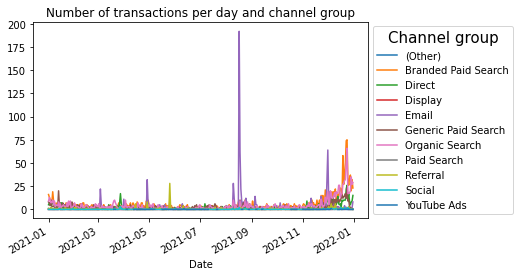

In [190]:
df_not_giving_tuesday_grouped_by_channel.unstack()['Transactions'].plot()
plt.title('Number of transactions per day and channel group')
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Channel group	

* Make sure that order remains the same for all plots - to be able to compare them better
* Distribution of channel groups is different in terms of clients ID and transactions, see plots
* Interesting for this MT - check differences in conversions per channel groups

In [158]:
df_extended['Channel group'].value_counts()
# set order - depending on number of channel groups, per year and for all data 
order = ['Email', 'Branded Paid Search', 'Organic Search', 'Generic Paid Search', 'Direct', 'Referral', 'Social', 'Display', '(Other)', 'YouTube Ads', 'Paid Search']

Organic Search         173513
Display                 94138
Branded Paid Search     48245
Direct                  41347
Generic Paid Search     38572
Referral                24468
Social                  18208
Email                   15690
(Other)                 13282
YouTube Ads              2968
Paid Search              1101
Name: Channel group, dtype: int64

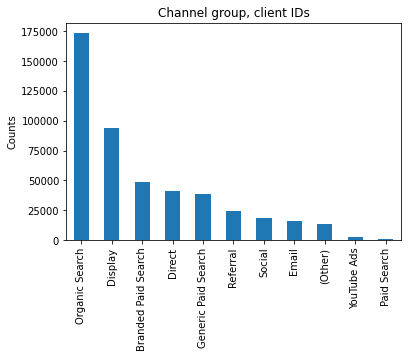

In [172]:
# plot of channel group 
#plt.subplot(1, 2, 1) # row 1, col 2 index 1

df_extended['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, client IDs')

#plt.subplot(1, 2, 2) # index 2
#df_transactions['Channel group'].value_counts().plot(kind='bar')
#plt.ylabel('Counts')
#plt.title('Channel group, just transactions')

# minimize overlap 
#plt.tight_layout()

plt.show()

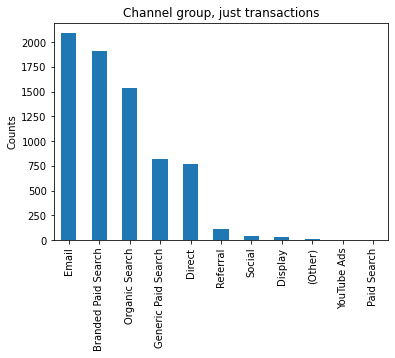

In [173]:
df_transactions['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, just transactions')
plt.show()

Check percentage of conversions per channel

In [170]:
tab = pd.crosstab(index=df_extended['Channel group'], columns='perc')
tab/tab.sum() * 100

col_0,perc
Channel group,
(Other),2.816776
Branded Paid Search,10.231543
Direct,8.768652
Display,19.964287
Email,3.327452
Generic Paid Search,8.180145
Organic Search,36.797715
Paid Search,0.233494
Referral,5.189043


In [171]:
pd.crosstab(index = df_extended['Channel group'], columns = df_extended['Transactions'])

Transactions,0,1,2,3,4,5,6,7,8,16,17,22,205
Channel group,,,,,,,,,,,,,
(Other),13228,10,1,0,0,0,0,0,0,0,0,0,43
Branded Paid Search,46009,1796,57,8,1,1,0,0,1,1,0,0,371
Direct,40320,702,26,6,1,0,0,0,1,0,0,0,291
Display,94001,25,0,0,0,0,0,0,0,0,0,0,112
Email,12630,772,20,2,0,1,0,0,0,0,1,0,2264
Generic Paid Search,37428,785,26,2,0,0,0,0,0,0,0,0,331
Organic Search,171144,1433,52,10,2,2,3,1,0,0,0,0,866
Paid Search,1100,1,0,0,0,0,0,0,0,0,0,0,0
Referral,24233,95,9,1,2,1,1,0,0,0,0,1,125


#### Focus: #GivingTuesday (2021-11-30)

In previous plots we have seen that a peak exists in number of (unique) clients IDs, and specially on number of transactions. We therefore would like to check: 

* What is the "normal" ratio of transactions/client IDs, and what is the ratio on #GivingTuesday 

* What is the number of new client IDs (i.e. client IDs that did not appear in the dataset before that day, for the whole 2021)

* Transactions coming from new vs repeated client IDs 

* Proportion of source channels on #GivingTuesday vs rest of year 

In 2020, the date with highest number of transactions of the year is 01.12.2020. As a reminder, that date was 30.11 in 2021. 

**That correspond to #givingTuesday 2020 (01.12) and 2021 (30.11)** 

TODO 
* Figure out if we should get rid of information/transactions on giving Tuesday - or just study the behavior on that specific day vs rest of days 
* Figure out if some other special marketing campaigns exist during the year and try to consider if they may have an effect on the analysis 
* Consider if substituting number of transactions in giving tuesday with value of second peak makes any sense 